In [1]:
import pandas as pd
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random

from PIL import Image
#import albumentations as A
#import tensorflow_datasets as tfds
#import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow. keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
#from google.colab import drive

In [2]:
import tensorflow as tf

# Check GPU availability using the recommended function
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Num GPUs Available: ", len(physical_devices))
else:
    print("No GPU available.")

# Check TensorFlow is using GPU
print("TensorFlow is using GPU: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
TensorFlow is using GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf

# Check GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  1


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14193969055026098176
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 756153109672372309
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [7]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [8]:
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_GPU_THREAD_COUNT'] = '1'


In [9]:
import os
os.environ['TF_GPU_MEMORY_TRACE'] = '1'

In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 16,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [3]:
train_directory = "dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "dataset/Emotions Dataset/Emotions Dataset/test"

# Wandb Installation

In [12]:
!pip install wandb

In [13]:
import wandb
from wandb.keras import WandbCallback

In [14]:
!wandb login

wandb: Currently logged in as: shubhankar-2021msc23 (shubh9934). Use `wandb login --relogin` to force relogin


In [15]:
wandb.init(project="Emotion-Detection", entity="shubh9934")

wandb: Currently logged in as: shubhankar-2021msc23 (shubh9934). Use `wandb login --relogin` to force relogin


In [16]:
wandb.config = CONFIGURATION

# Data Management

## Data Downloading

## Dataset Loading
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [5]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [6]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 89.      ,  89.      ,  89.      ],
         [ 91.4375  ,  91.4375  ,  91.4375  ],
         [ 85.8125  ,  85.8125  ,  85.8125  ],
         ...,
         [ 26.6875  ,  26.6875  ,  26.6875  ],
         [ 26.      ,  26.      ,  26.      ],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 79.25    ,  79.25    ,  79.25    ],
         [ 86.30859 ,  86.30859 ,  86.30859 ],
         [ 87.89453 ,  87.89453 ,  87.89453 ],
         ...,
         [ 25.875   ,  25.875   ,  25.875   ],
         [ 25.339844,  25.339844,  25.339844],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 71.5     ,  71.5     ,  71.5     ],
         [ 79.625   ,  79.625   ,  79.625   ],
         [ 87.60156 ,  87.60156 ,  87.60156 ],
         ...,
         [ 24.570312,  24.570312,  24.570312],
         [ 23.253906,  23.253906,  23.253906],
         [ 24.625   ,  24.625   ,  24.625   ]],

        ...,

        [[170.      , 170.      ,

## Dataset Visualization

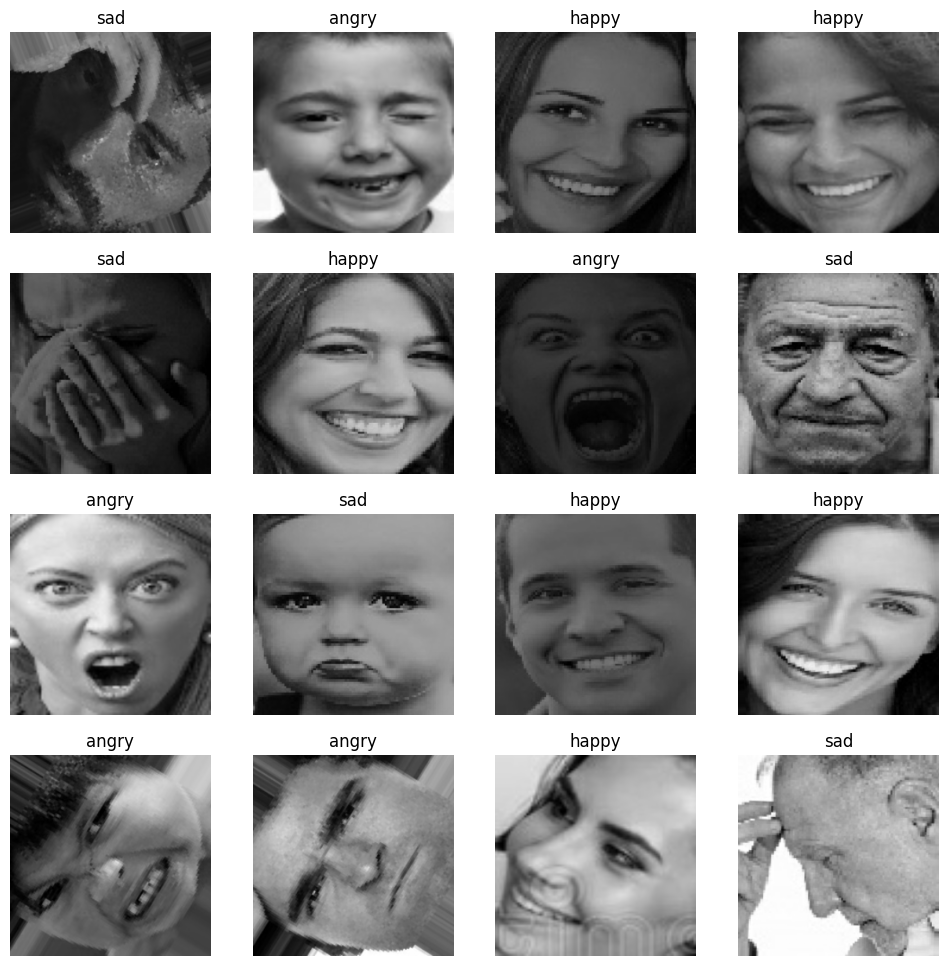

In [7]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## Data Augmentation

In [8]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [9]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

### Cutmix Augmentation

In [10]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [11]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Dataset Preparation

In [12]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [13]:

# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [14]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [15]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [16]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [17]:
training_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Modeling

## Lenet

In [32]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## ResNet34

### CustomConv2D

In [33]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

### Residual Block

In [34]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


### Complete Network

In [35]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [36]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

## Transfer Learning with EfficientNet

https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB4


In [37]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

In [38]:
backbone.trainable = False

In [39]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_40 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 128)               131200    
                                                                 
 dense_6 (Dense)             (None, 3)                

## Transfer Learning with MobileNetV2

https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2

In [40]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

In [41]:
backbone.trainable = False

In [42]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              1311744   
                                                                 
 batch_normalization_41 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                      

## FineTuning EficientNet

In [43]:
backbone.trainable = True

In [44]:
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)

In [45]:
finetuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 1024)              1311744   
                                                                 
 batch_normalization_42 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                             

## Vision Transformers
https://www.tensorflow.org/api_docs/python/tf/image/extract_patches

https://arxiv.org/abs/2010.11929v2

### Patch Encoder

In [46]:
test_image = cv2.imread("dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [47]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [48]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


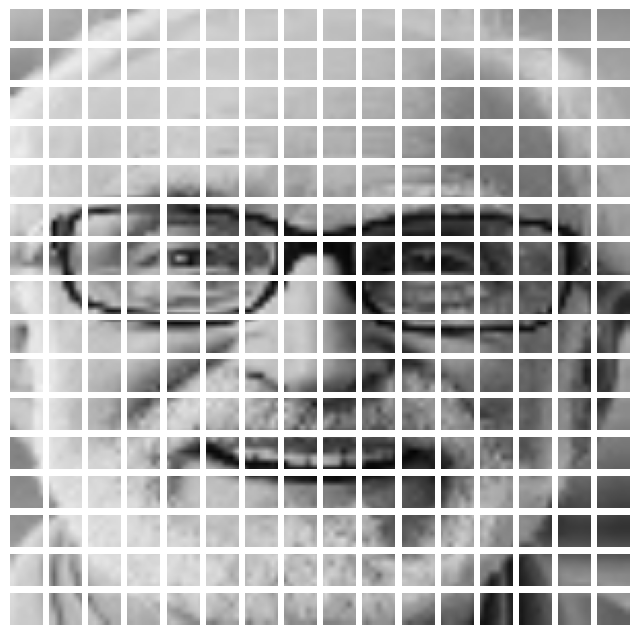

In [49]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

In [50]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

### TransformerEncoder

https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention

In [51]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

### ViT Model

In [52]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [53]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))

<tf.Tensor: shape=(2, 3), dtype=float16, numpy=
array([[0.4536, 0.2935, 0.2532],
       [0.4536, 0.2935, 0.2532]], dtype=float16)>

In [54]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncoder  multiple                 787200    
 )                                                               
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 dense_18 (Dense)            multiple                  25165952  
                                                                 
 dense_19 (Dense)            multiple                  16512     
                                                

## HuggingFace ViT

https://huggingface.co/docs/transformers/model_doc/vit#overview

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization

### Installation

In [19]:
!pip install transformers

In [23]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.Collecting torch
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.7 MB 1.9 MB/s eta 0:00:03
      --------------------------------------- 0.1/5.7 MB 1.6 MB/s eta 0:00:04
     - -------------------------------------- 0.2/5.7 MB 2.5 MB/s eta 0:00:03
     --- ------------------------------------ 0.5/5.7 MB 3.6 MB/s eta 0:00:02
     ----- ---------------------------------- 0.7/5.7 MB 3.8 MB/s eta 0:00:02
     ------ --------------------------------- 1.0/5.7 MB 4.2 MB/s eta 0:00:02
     ------- -------------------------------- 1.1/5.7 MB 4.3 MB/s eta 0:00:02
     --------- ------------------------------ 1.3/5.7 MB 4.4 MB/s eta 0:00:01
     ---------- ----------------------------- 1.5/5.7 MB 4.4 MB/s eta 0:00:01
     ----------- ---------------------------- 1.7/5.7 MB 4.4 MB/s eta 0:00:01
     ----------- ---------------------------- 1.7/5.7 MB 4.4 MB/s e

### Training

In [20]:
resize_rescale_hf = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
       Permute((3,1,2))
])

In [25]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

ImportError: 
ViTModel requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFViTModel".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [ ]:
configuration

In [22]:
from transformers import AutoImageProcessor, TFViTModel


base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (256 ,256 ,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:]
print(x)
output = Dense(3, activation = 'softmax')(x)
print(output)
hf_model = tf.keras.Model(inputs = inputs , outputs = output)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [27]:
import cv2
test_image = cv2.imread("dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [28]:
hf_model(tf.expand_dims(test_image, axis = 0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.4043545 , 0.25905782, 0.33658767]], dtype=float32)>

In [29]:
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0     

In [30]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [31]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [32]:
hf_model.compile(
  optimizer = Adam(learning_rate = 5e-5),#CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [35]:
history = hf_model.fit(
  training_dataset,
  #validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'model/vit/encoder/layer_._2/attention/attention/Softmax' defined at (most recent call last):
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\shubh\AppData\Local\Temp\ipykernel_13868\2965602866.py", line 1, in <module>
      history = hf_model.fit(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\transformers\modeling_tf_utils.py", line 506, in run_call_with_unpacked_inputs
      # EagerTensors don't allow to use the .name property so we check for a real Tensor
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 519, in call
      encoder_outputs = self.encoder(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 438, in call
      for i, layer_module in enumerate(self.layer):
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 442, in call
      layer_outputs = layer_module(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 394, in call
      attention_outputs = self.attention(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 322, in call
      self_outputs = self.self_attention(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 264, in call
      attention_probs = stable_softmax(logits=attention_scores, axis=-1)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\transformers\tf_utils.py", line 70, in stable_softmax
      return tf.nn.softmax(logits=logits + 1e-9, axis=axis, name=name)
Node: 'model/vit/encoder/layer_._2/attention/attention/Softmax'
OOM when allocating tensor with shape[16,12,197,197] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/vit/encoder/layer_._2/attention/attention/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_34402]

### Get Attention Maps

In [61]:

from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig

configuration = ViTConfig()
configuration.output_attentions = True

base_model = TFViTModel.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    config = configuration,
    )
inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)['attentions']

model = tf.keras.Model(inputs=inputs, outputs=x)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


# Training

## Class Weighting

In [62]:
n_sample_0 = 1525 # angry
n_sample_1 = 3019 # happy
n_sample_2 = 2255 # sad


In [63]:
class_weights = {0:6799/n_sample_0, 1: 6799/n_sample_1, 2: 6799/n_sample_2}

In [64]:
print(class_weights)

{0: 4.458360655737705, 1: 2.2520702219277906, 2: 3.015077605321508}


## Callbacks

https://docs.wandb.ai/ref/python/integrations/keras/wandbmodelcheckpoint

In [65]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

In [66]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})

In [67]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):

    columns=["image", "Predicted", "Label"]

    val_table = wandb.Table(columns = columns)


    for im, label in validation_dataset.take(25):

      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]

      val_table.add_data(*row)


    wandb.log({"Model Results" : val_table})


## Train

In [68]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [69]:

metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [70]:
hf_model.compile(
  optimizer = Adam(learning_rate = 5e-5),
  loss = loss_function,
  metrics = metrics,
)

In [71]:
history = hf_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = 20,#CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20


ResourceExhaustedError: in user code:

    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 997, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\mixed_precision\loss_scale_optimizer.py", line 837, in apply_gradients
        maybe_apply_op = tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\mixed_precision\loss_scale_optimizer.py", line 835, in apply_fn
        return self._apply_gradients(grads, wrapped_vars, name)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\mixed_precision\loss_scale_optimizer.py", line 876, in _apply_gradients
        return self._optimizer.apply_gradients(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 695, in apply_gradients
        self._create_all_weights(var_list)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 959, in _create_all_weights
        self._create_slots(var_list)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py", line 128, in _create_slots
        self.add_slot(var, "v")
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1050, in add_slot
        weight = tf.Variable(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\initializers\initializers_v2.py", line 171, in __call__
        return tf.zeros(shape, dtype)

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[768,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


In [70]:
backbone.trainable=False

In [71]:
pretrained_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [72]:
history = pretrained_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = 20,#CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20
425/425 [==============================] - 190s 437ms/step - loss: 3.3178 - accuracy: 0.5339 - top_k_accuracy: 0.8209 - val_loss: 1.1276 - val_accuracy: 0.5035 - val_top_k_accuracy: 0.8082
Epoch 2/20
425/425 [==============================] - 179s 419ms/step - loss: 2.6750 - accuracy: 0.6035 - top_k_accuracy: 0.8569 - val_loss: 0.8485 - val_accuracy: 0.6172 - val_top_k_accuracy: 0.8560
Epoch 3/20
425/425 [==============================] - 185s 433ms/step - loss: 2.4388 - accuracy: 0.6426 - top_k_accuracy: 0.8797 - val_loss: 0.8869 - val_accuracy: 0.6054 - val_top_k_accuracy: 0.8635
Epoch 4/20
425/425 [==============================] - 188s 440ms/step - loss: 2.3796 - accuracy: 0.6538 - top_k_accuracy: 0.8854 - val_loss: 0.9813 - val_accuracy: 0.5329 - val_top_k_accuracy: 0.8442
Epoch 5/20
425/425 [==============================] - 190s 446ms/step - loss: 2.2691 - accuracy: 0.6757 - top_k_accuracy: 0.8944 - val_loss: 0.8750 - val_accuracy: 0.6115 - val_top_k_accuracy: 0.8714


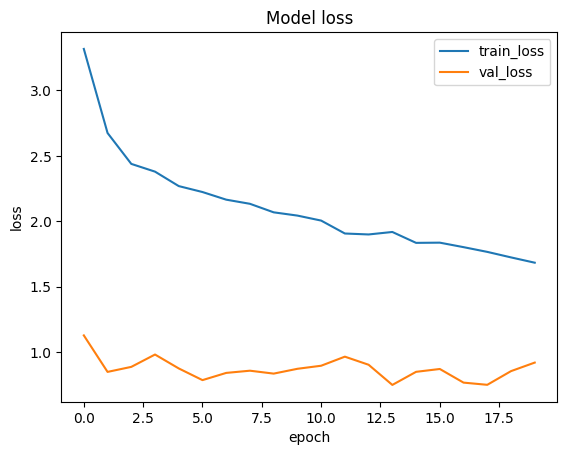

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

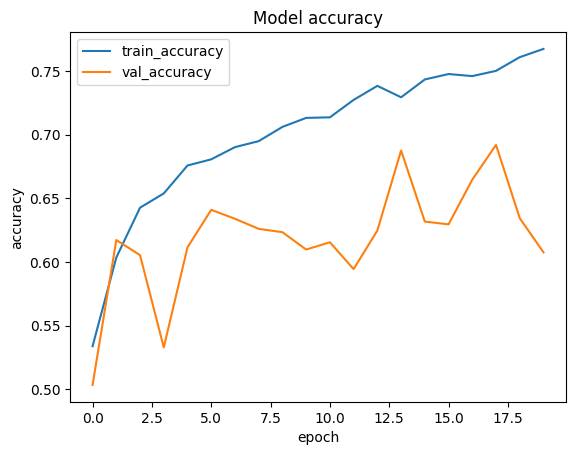

In [74]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [76]:
pretrained_model.save("drive/MyDrive/Bang/mobilenet_human_emotions.h5")

**LENET_MODEL**

In [78]:
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = 'sparse_categorical_crossentropy',#loss_function,
  metrics = metrics,
)

In [5]:
lenet_history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

NameError: name 'lenet_model' is not defined

In [ ]:
plt.plot(lenet_history.history['loss'])
plt.plot(lenet_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(lenet_history.history['accuracy'])
plt.plot(lenet_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

**RESNET_34_MODEL**

In [ ]:
resnet_34.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
resnet_34_history = resnet_34.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

In [ ]:
plt.plot(resnet_34_history.history['loss'])
plt.plot(resnet_34_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(resnet_34_history.history['accuracy'])
plt.plot(resnet_34_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

**FINETURNED_EFFICIENT_MODEL**

In [ ]:
finetuned_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
finetuned_model_history = finetuned_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

In [ ]:
plt.plot(finetuned_model_history.history['loss'])
plt.plot(finetuned_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(finetuned_model_history.history['accuracy'])
plt.plot(finetuned_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

**VIT_MODEL**

In [ ]:
vit.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
vit_history = vit.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

In [ ]:
plt.plot(vit_history.history['loss'])
plt.plot(vit_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(vit_history.history['accuracy'])
plt.plot(vit_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

**HuggingFace_ViT_Model**

In [ ]:
hf_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
hf_model_history = hf_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

In [ ]:
plt.plot(hf_model_history.history['loss'])
plt.plot(hf_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(hf_model_history.history['accuracy'])
plt.plot(hf_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## Ensembling

In [73]:
inputs = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))

y_1 = resnet_34(inputs)
y_2 = pretrained_model(inputs) # Mobile Net
y_3 = lenet_model(inputs)
y_4 = finetuned_model(inputs) # Efficient Net
y_5 = vit(inputs) # VIT

output = 0.2*y_1 + 0.2*y_2 + 0.2*y_3 + 0.2*y_4 + 0.2*y_5

ensemble_model = Model(inputs = inputs, outputs = output)

In [74]:
test_image = cv2.imread("dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [75]:
ensemble_model(tf.expand_dims(test_image, axis = 0))

NotFoundError: Exception encountered when calling layer "Conv1" "                 f"(type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18356512 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes. [Op:Conv2D]

Call arguments received by layer "Conv1" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(1, 256, 256, 3), dtype=float16)

In [76]:
ensemble_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet_34 (ResNet34)           (None, 3)            21311747    ['input_9[0][0]']                
                                                                                                  
 sequential_4 (Sequential)      (None, 3)            3705411     ['input_9[0][0]']                
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 3)            0           ['resnet_34[0][0]']        

In [77]:
ensemble_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [78]:
ensemble_model_history = ensemble_model.fit(
  training_dataset,
  #validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20


ResourceExhaustedError: in user code:

    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\engine\training.py", line 997, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\mixed_precision\loss_scale_optimizer.py", line 837, in apply_gradients
        maybe_apply_op = tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\mixed_precision\loss_scale_optimizer.py", line 835, in apply_fn
        return self._apply_gradients(grads, wrapped_vars, name)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\mixed_precision\loss_scale_optimizer.py", line 876, in _apply_gradients
        return self._optimizer.apply_gradients(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 695, in apply_gradients
        self._create_all_weights(var_list)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 959, in _create_all_weights
        self._create_slots(var_list)
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py", line 126, in _create_slots
        self.add_slot(var, "m")
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1050, in add_slot
        weight = tf.Variable(
    File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\keras\initializers\initializers_v2.py", line 171, in __call__
        return tf.zeros(shape, dtype)

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


# Evaluation

In [1]:
model.load_weights('best_weights')

NameError: name 'model' is not defined

In [34]:
hf_model.evaluate(validation_dataset)

2278/2278 [==============================] - 94s 39ms/step - loss: 1.0779 - accuracy: 0.3982 - top_k_accuracy: 0.7406


[1.0779378414154053, 0.3981562852859497, 0.7405619025230408]

# Testing

In [70]:
test_image = cv2.imread("dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(pretrained_model(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

tf.Tensor([[0.1289 0.2744 0.5967]], shape=(1, 3), dtype=float16)
sad


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

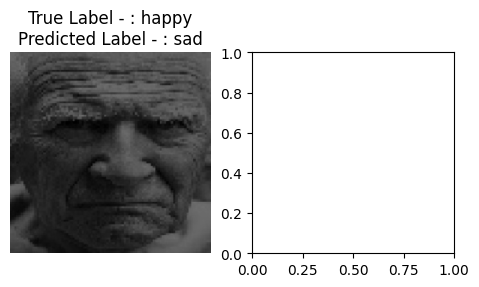

In [74]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(pretrained_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

## Confusion Matrix

In [75]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(pretrained_model(im))
  labels.append(label.numpy())

In [76]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 1 ... 0 2 1]
[2 2 2 ... 1 2 2]


In [77]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[  6  73 436]
 [  8 130 868]
 [  3  64 690]]


Text(0.5, 58.7222222222222, 'Predicted')

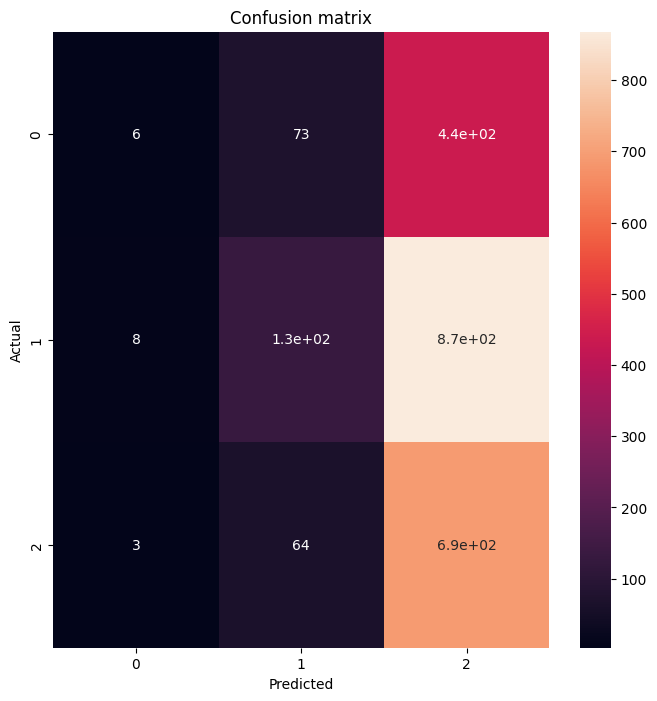

In [78]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Visualization

## Feature Map Visualization

In [79]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights= None,
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),

)

In [80]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [81]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [82]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [83]:
test_image = cv2.imread("dataset/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 1s 619ms/step


In [84]:
print(len(f_maps))

13


In [85]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


Error in callback <function _draw_all_if_interactive at 0x0000024E7A6C4430> (for post_execute):


MemoryError: In RendererAgg: Out of memory

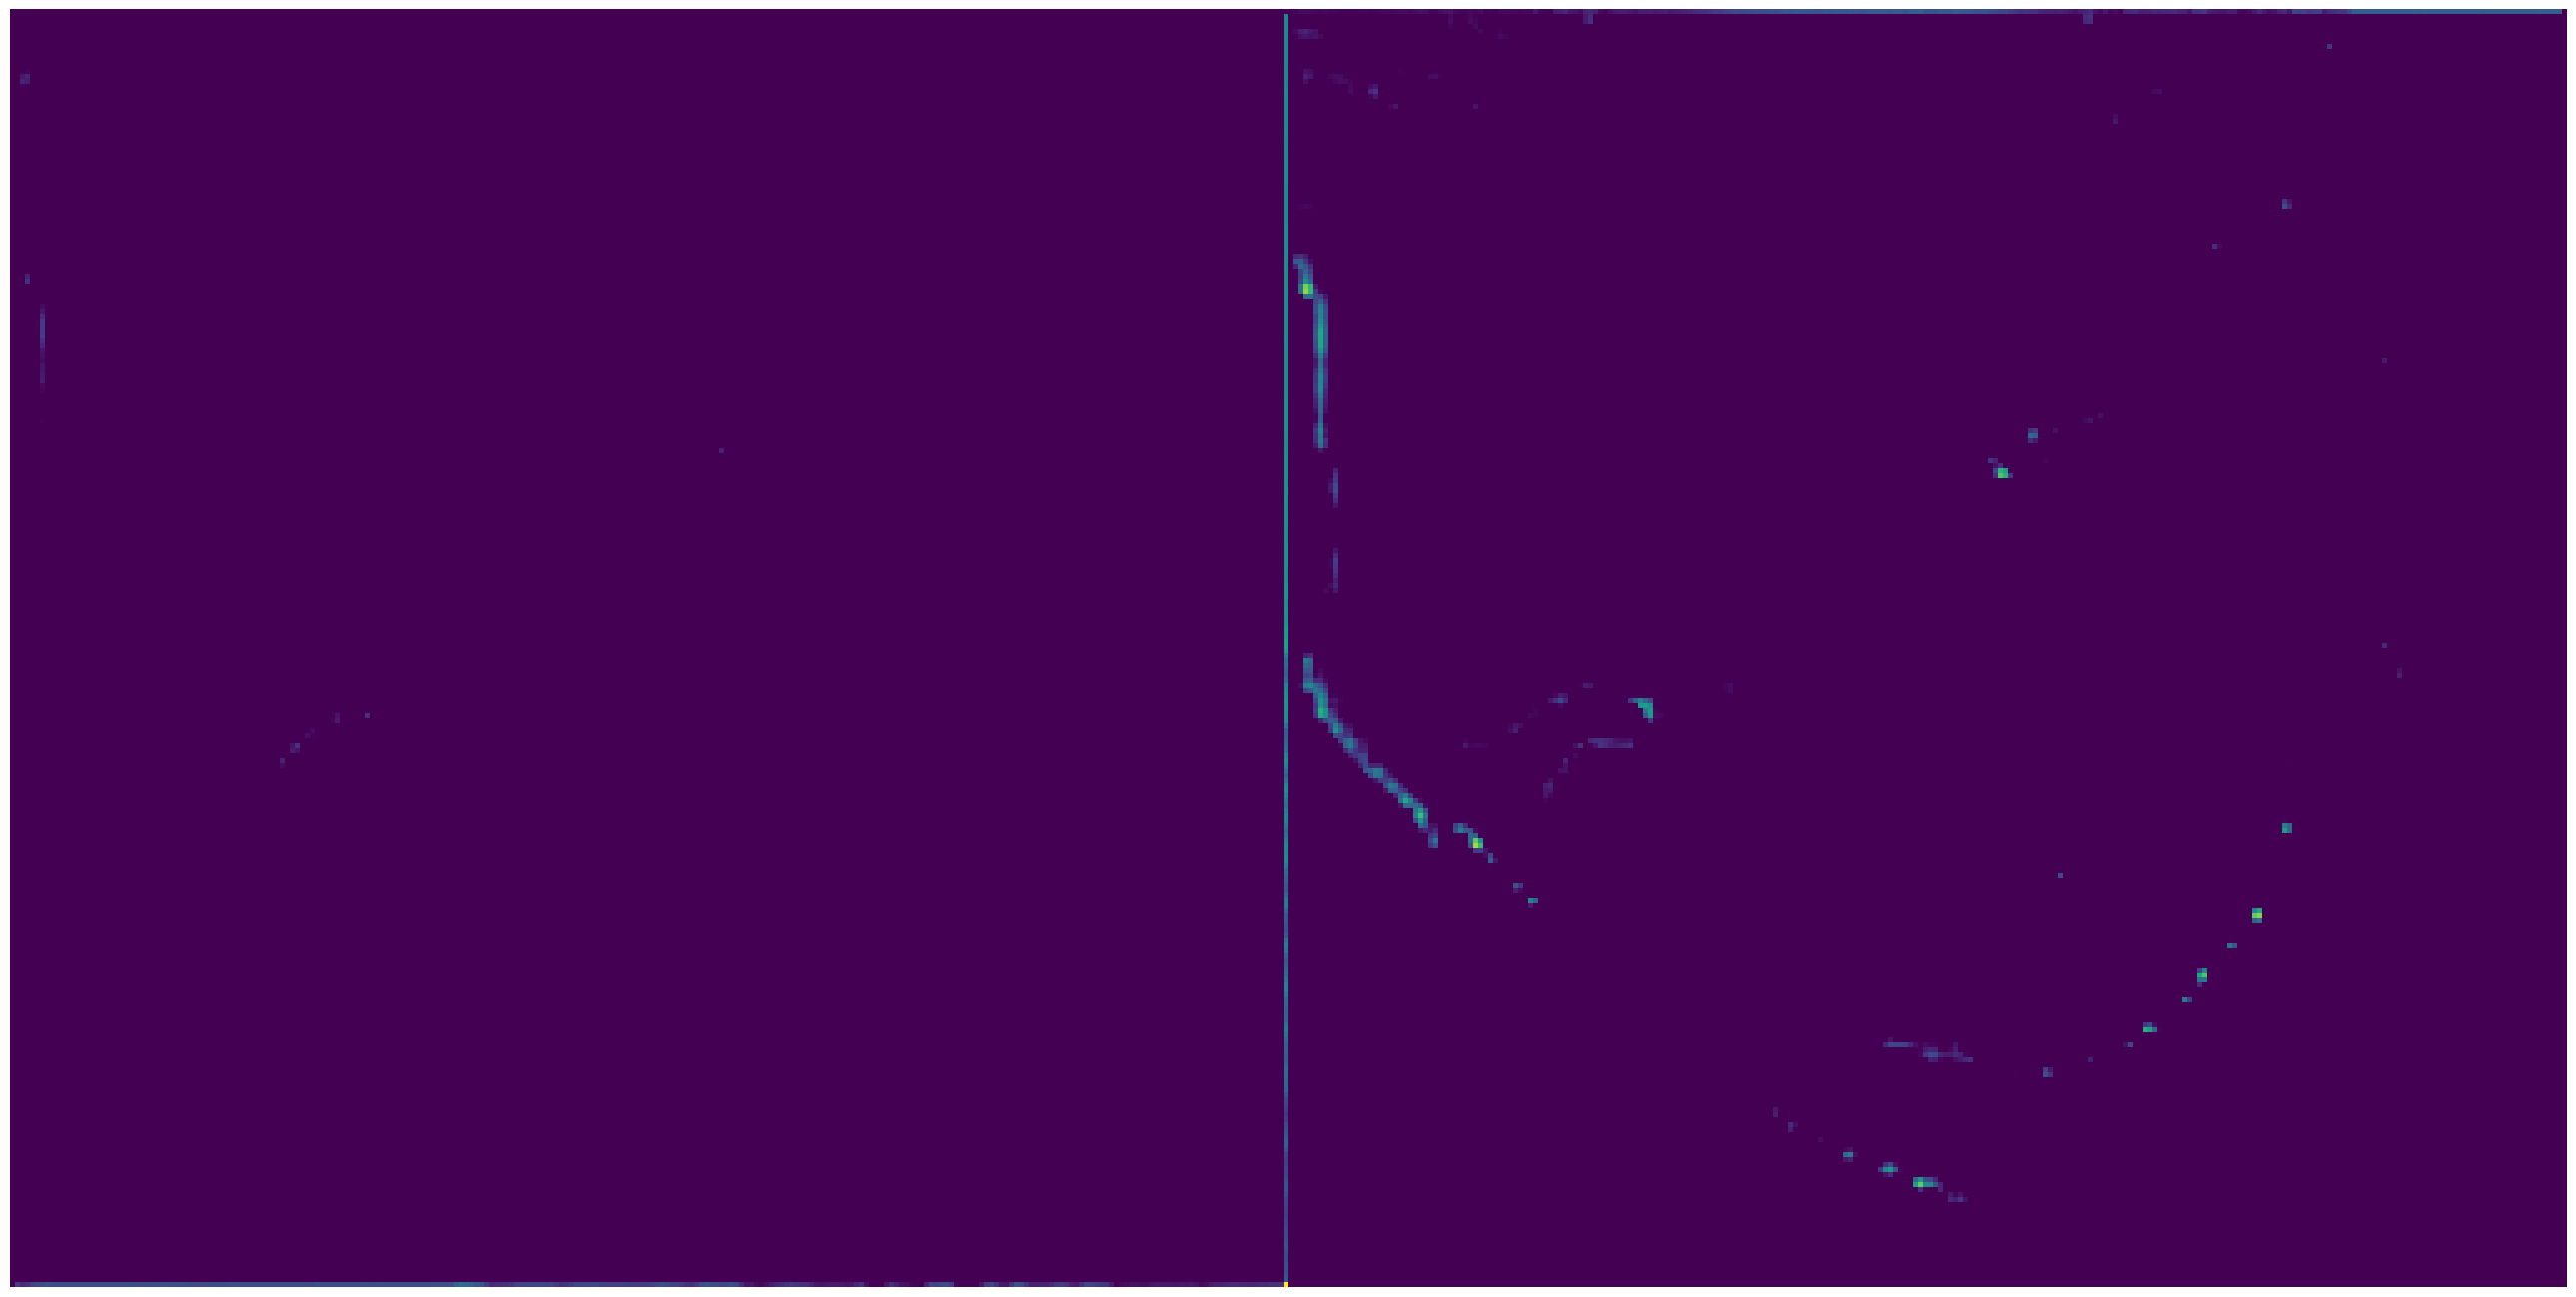

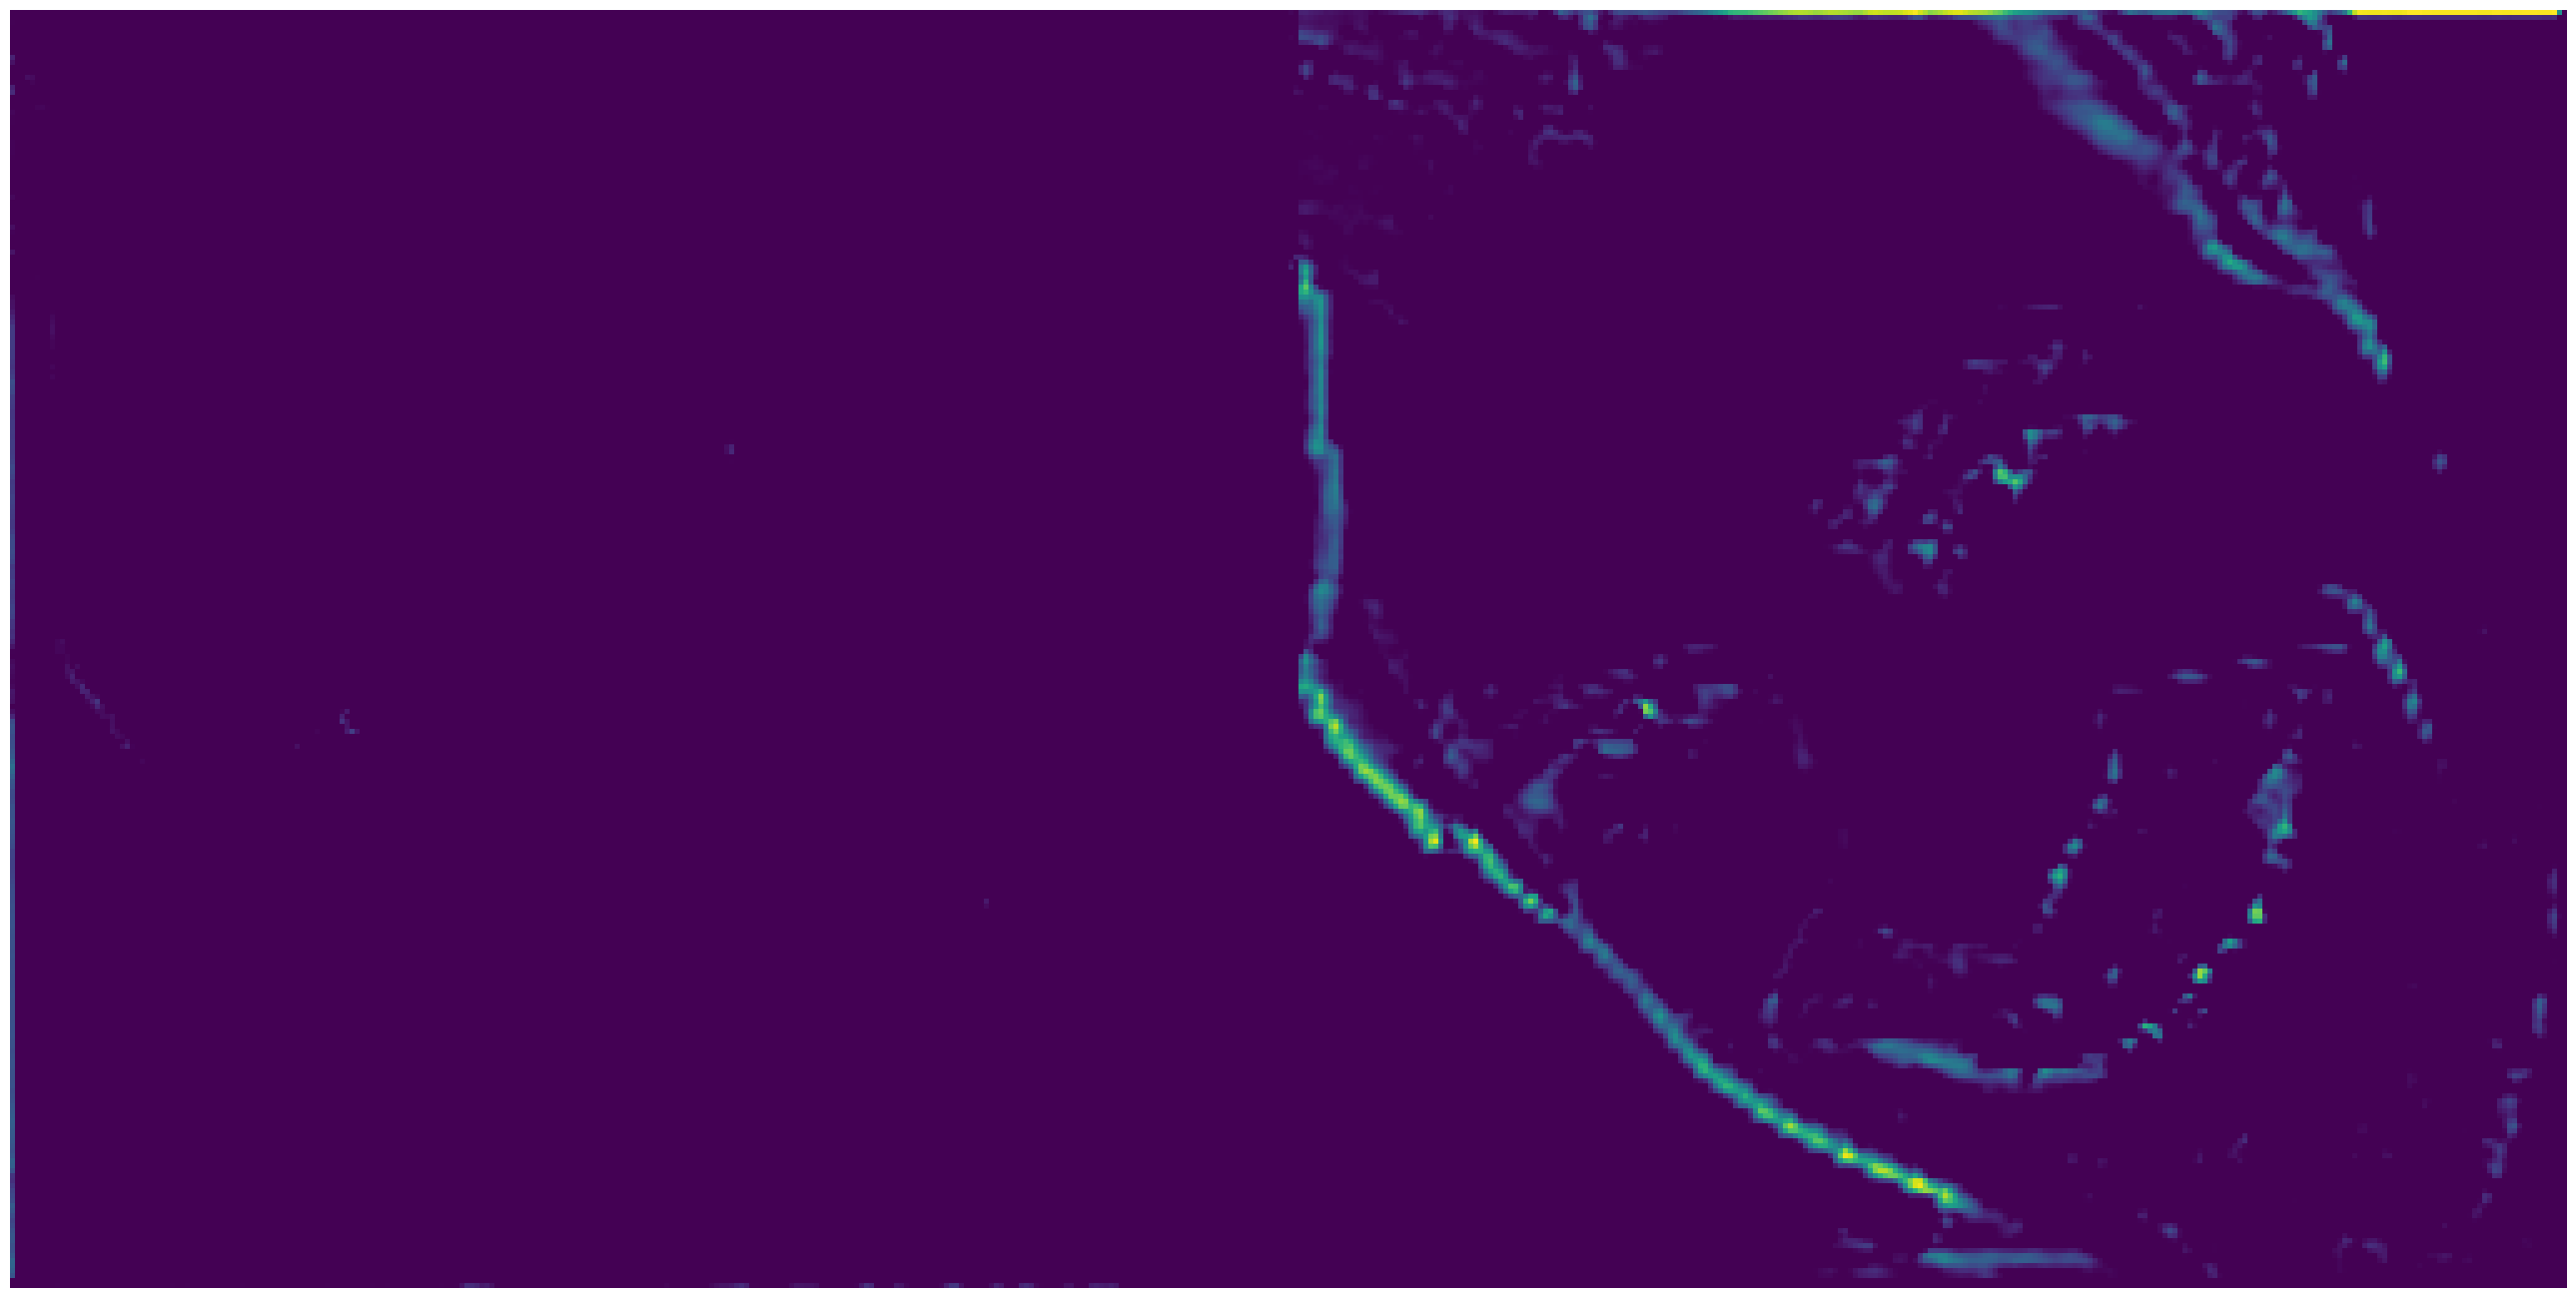

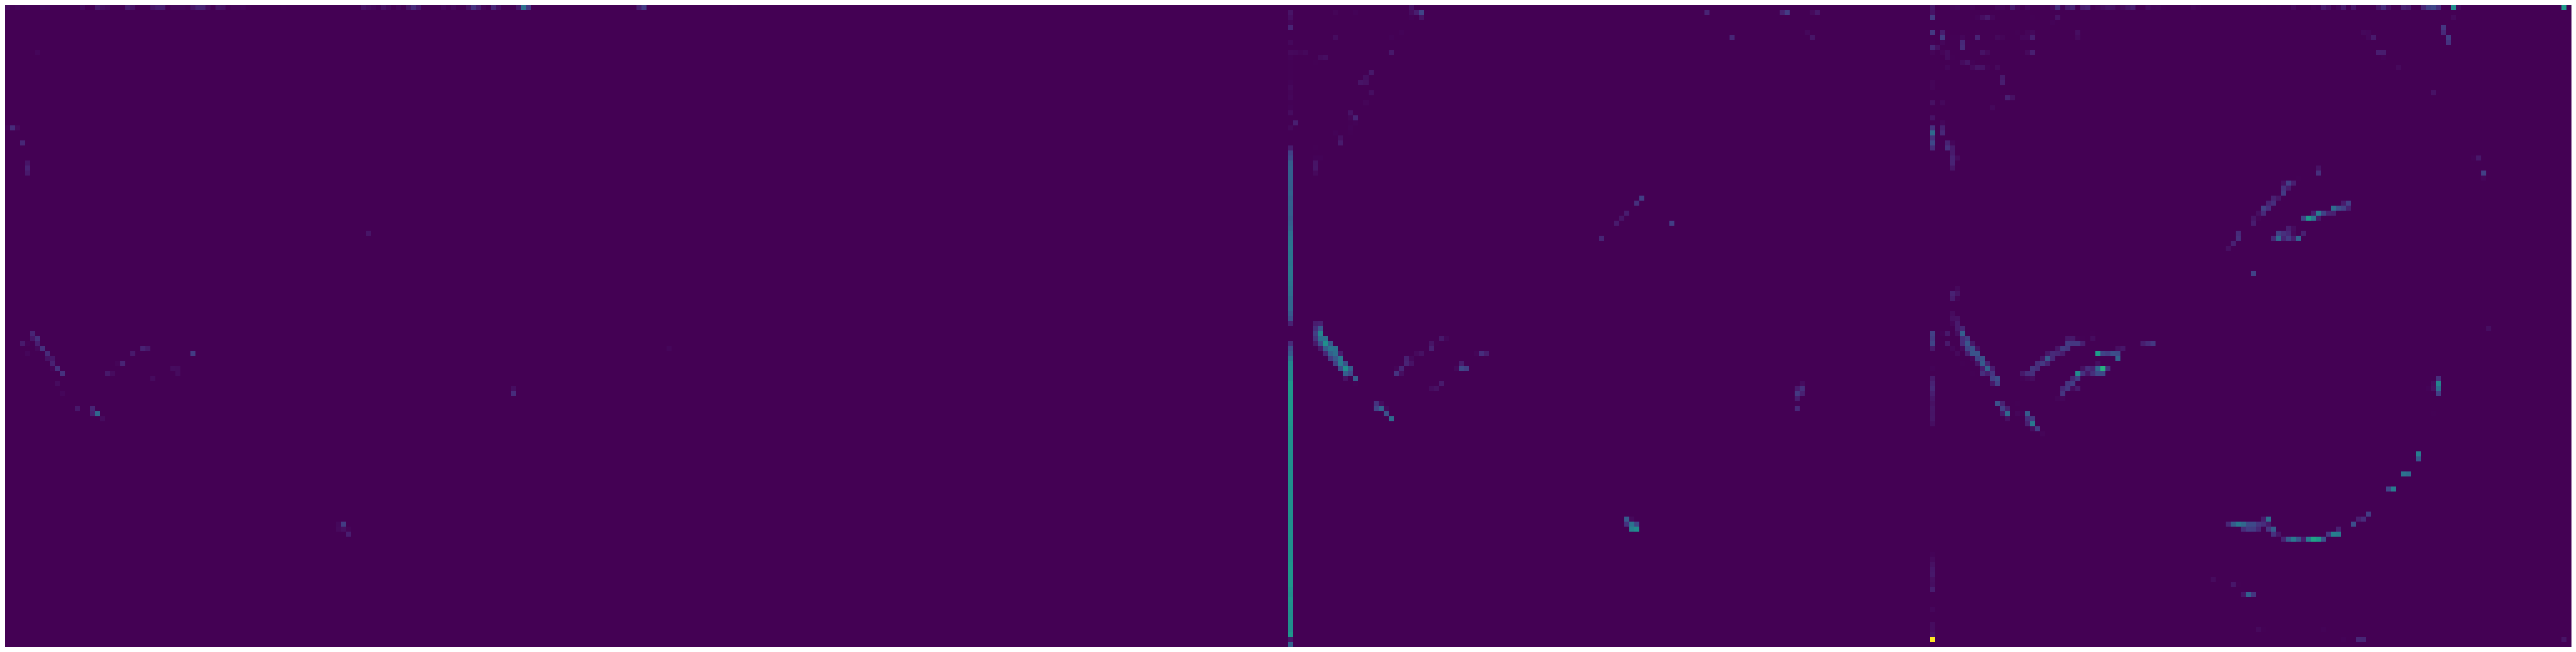

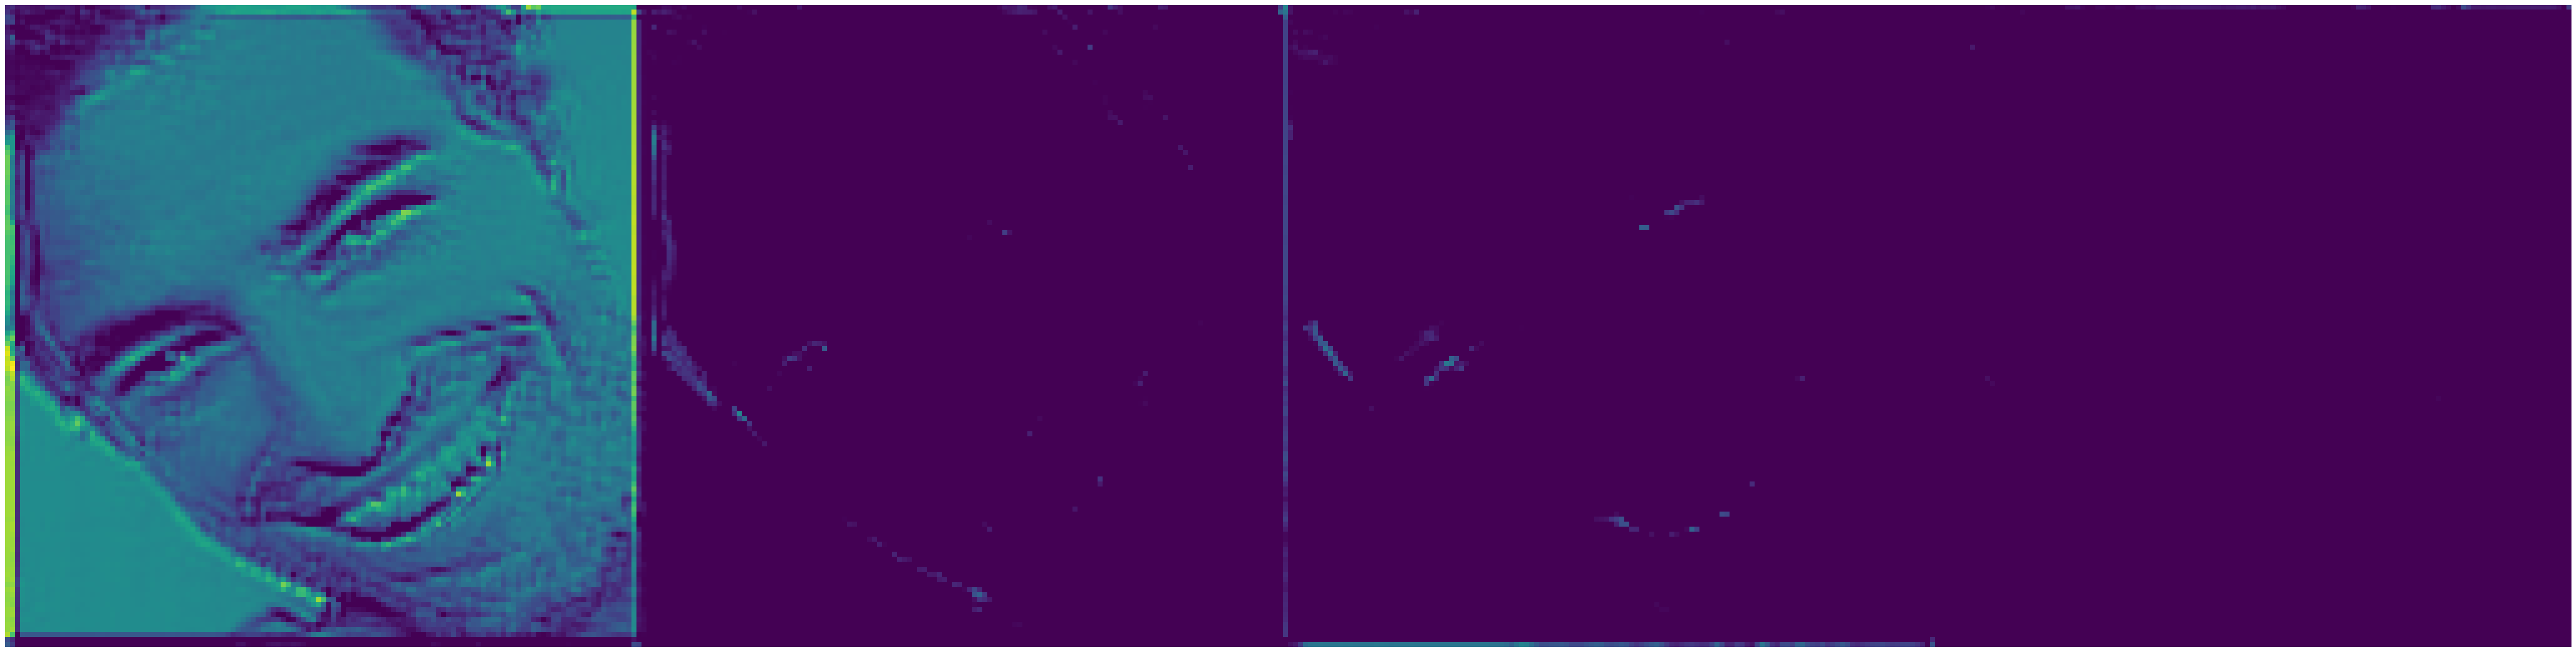

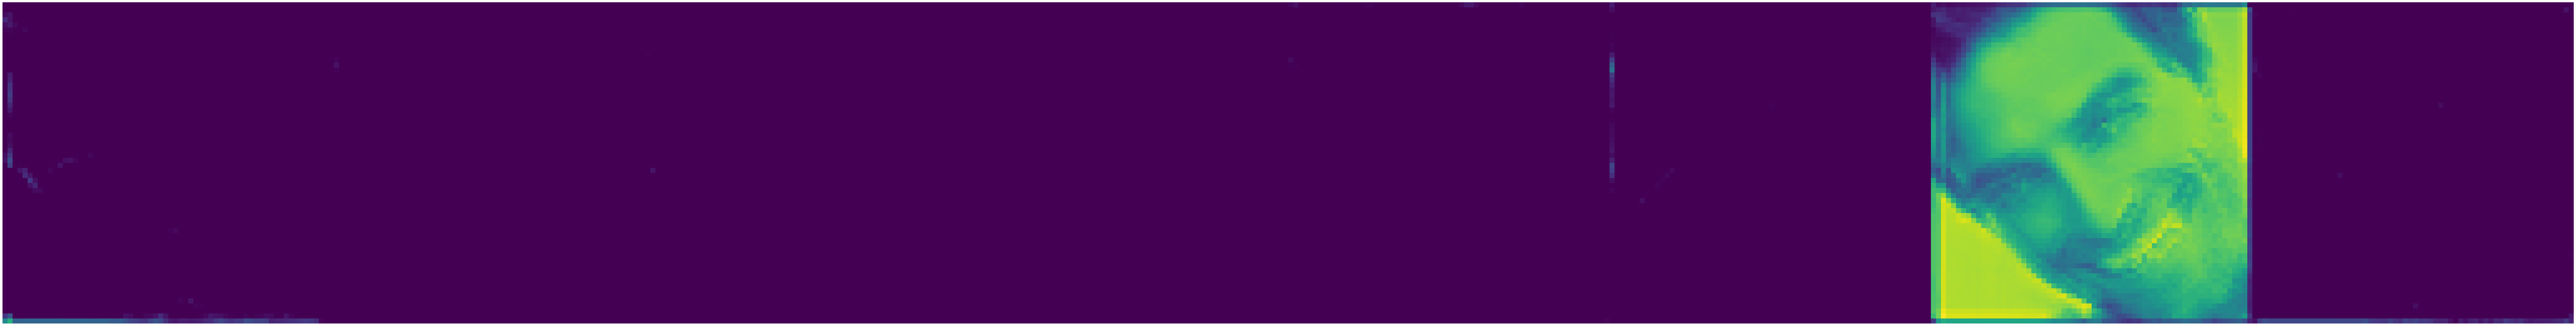

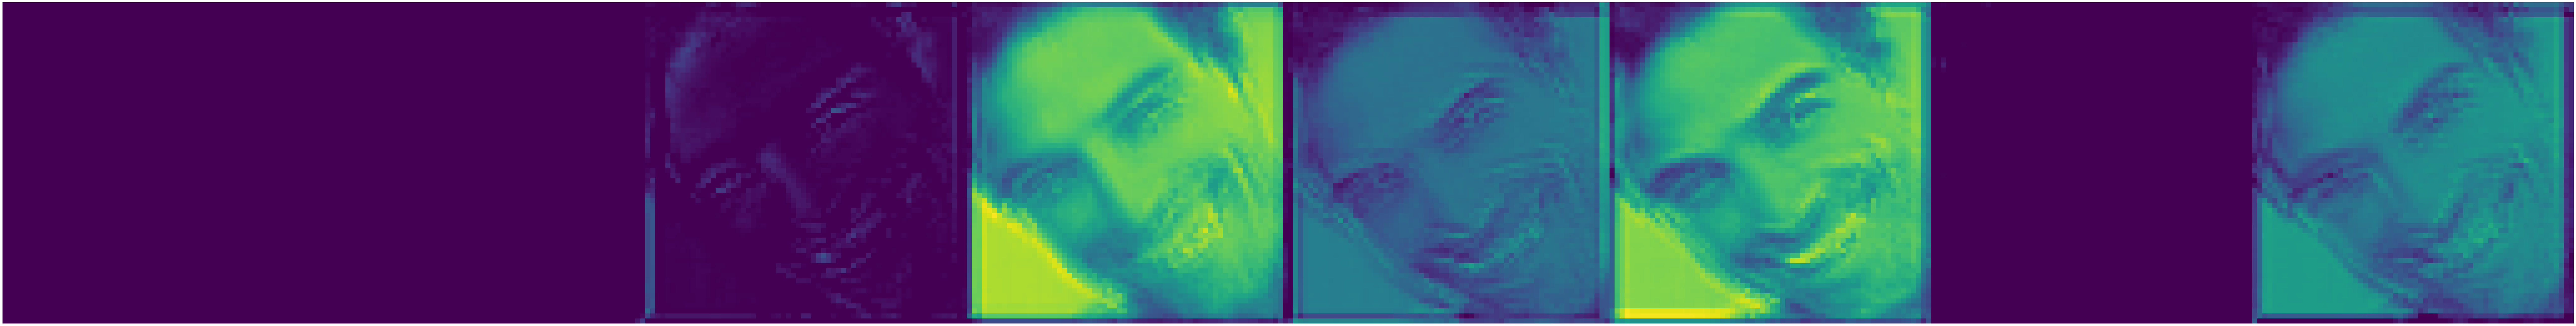

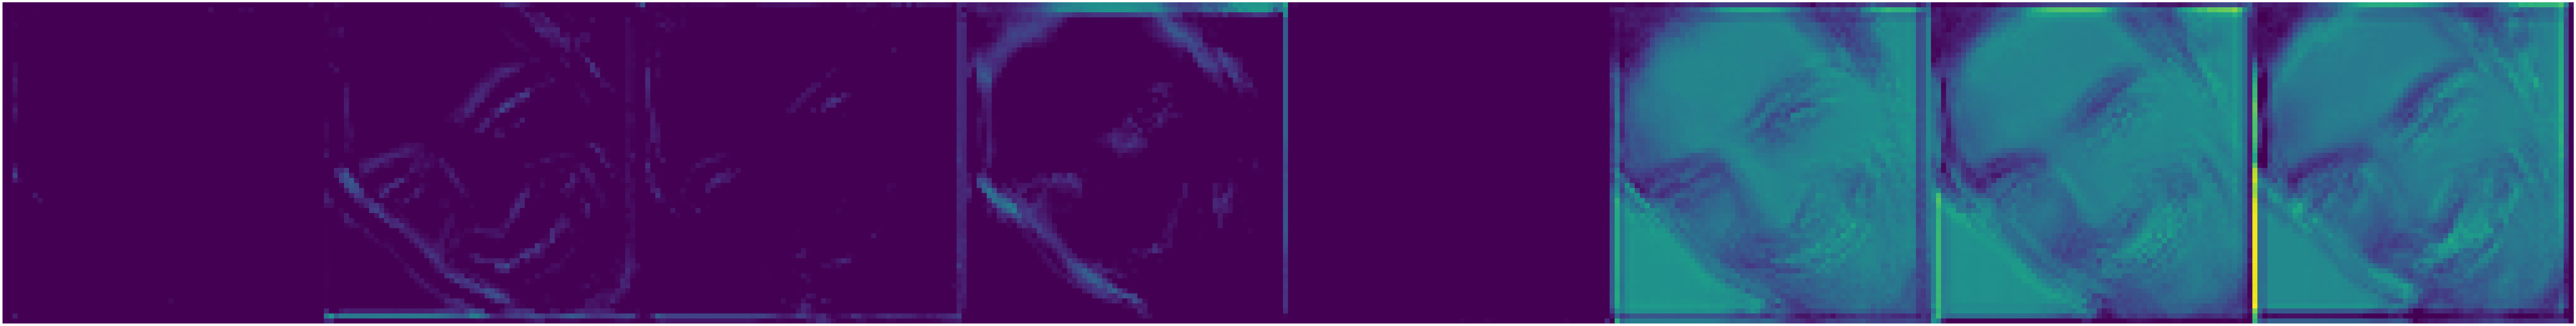

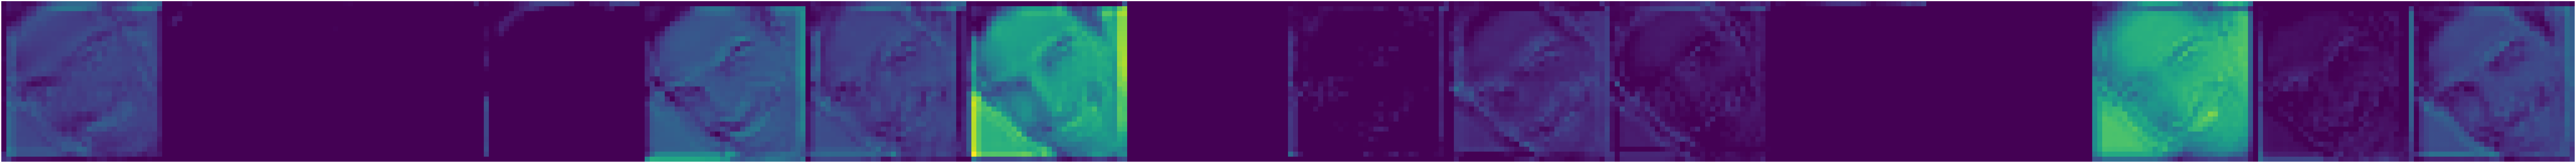

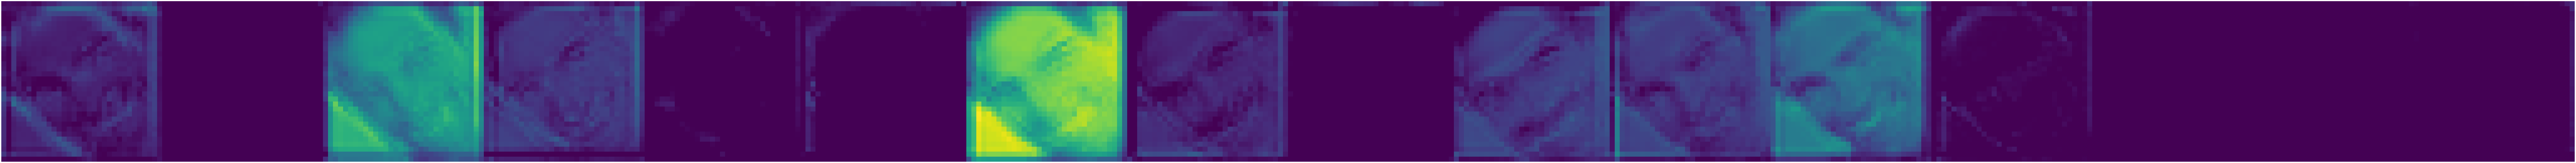

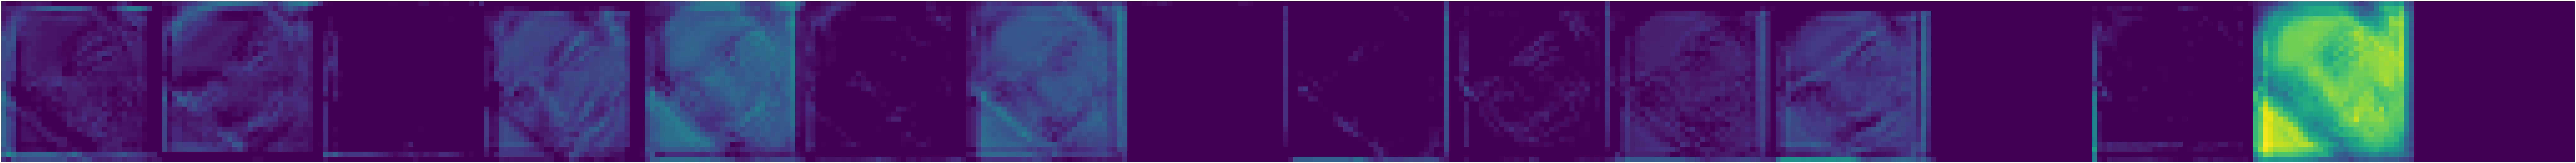

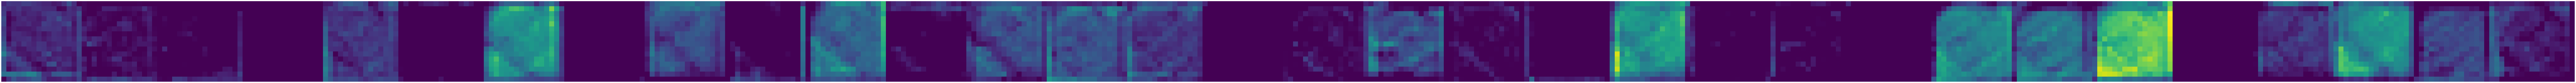

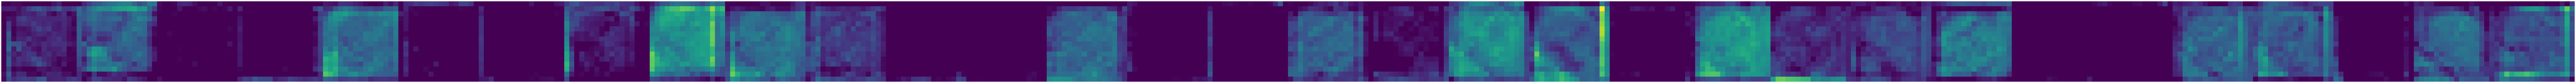

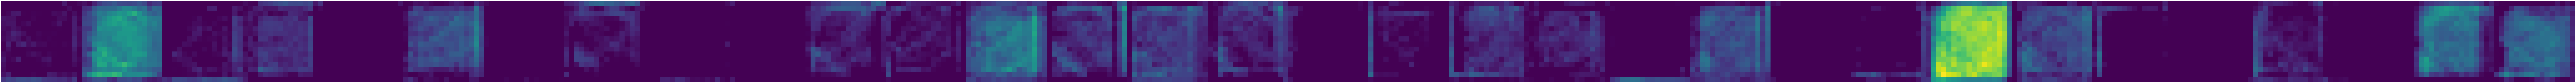

In [86]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels ))

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")


## GradCam

In [87]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

115263384/115263384 [==============================] - 33s 0us/step


In [88]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 256, 256, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

In [89]:
pretrained_model.load_weights('drive/MyDrive/Bang/mobilenet_human_emotions.h5')

ValueError: Layer count mismatch when loading weights from file. Model expected 314 layers, found 5 saved layers.

In [ ]:
img_path = "dataset/Emotions Dataset/Emotions Dataset/train/happy/202291.jpg"

In [ ]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

In [ ]:
preds = pretrained_model.predict(img_array)

In [ ]:
print(preds)

In [ ]:
np.argmax(preds[0])

In [ ]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
classifier_layer_names = [
 "global_average_pooling2d",
 "dense",
 "dense_1",
 "dense_2"
]

In [ ]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
grads.shape

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [ ]:
print(pooled_grads.shape)

In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
print(last_conv_layer_output.shape)

In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

In [ ]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

In [ ]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255+img_array[0,:,:,0]/255)

# Exporting to Onnx format

In [ ]:
hf_model.save('vit_finetuned')

INFO:tensorflow:Assets written to: vit_finetuned/assets


INFO:tensorflow:Assets written to: vit_finetuned/assets


In [ ]:
hf_model.save('vit_finetuned.h5')

## Installation

In [36]:
!pip install -U tf2onnx
!pip install onnxruntime-gpu

     ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
     - ----------------------------------- 30.7/904.0 kB 640.0 kB/s eta 0:00:02
     ---- --------------------------------- 112.6/904.0 kB 1.6 MB/s eta 0:00:01
     ---------- --------------------------- 256.0/904.0 kB 2.6 MB/s eta 0:00:01
     ---------------------- --------------- 542.7/904.0 kB 3.8 MB/s eta 0:00:01
     --------------------------------- ---- 788.5/904.0 kB 3.8 MB/s eta 0:00:01
     -------------------------------------- 904.0/904.0 kB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/454.7 kB ? eta -:--:--
   ----------------- ---------------------- 194.6/454.7 kB 5.9 MB/s eta 0:00:01
   ------------------------------------ --- 409.6/454.7 kB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 454.7/454.7 kB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   - -------------------------------------- 0.4/14.3 MB 10.9 MB/s 

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


     ---------------------------------------- 0.0/46.0 kB ? eta -:--:--
     ---------------- --------------------- 20.5/46.0 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 46.0/46.0 kB 567.9 kB/s eta 0:00:00
     ---------------------------------------- 0.0/86.8 kB ? eta -:--:--
     ---------------------------- ----------- 61.4/86.8 kB 1.7 MB/s eta 0:00:01
     ---------------------------------------- 86.8/86.8 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/95.2 kB ? eta -:--:--
     ---------------------------------------- 95.2/95.2 kB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/141.5 MB ? eta -:--:--
   ---------------------------------------- 0.2/141.5 MB 10.9 MB/s eta 0:00:13
   ---------------------------------------- 0.4/141.5 MB 6.3 MB/s eta 0:00:23
   ---------------------------------------- 0.6/141.5 MB 5.1 MB/s eta 0:00:28
   ---------------------------------------- 0.9/141.5 MB 5.1 MB/s eta 0:00:28


In [37]:
import onnxruntime as rt
rt.get_device()

'GPU'

In [38]:
pip install --upgrade protobuf==3.9.2


     ---------------------------------------- 0.0/431.5 kB ? eta -:--:--
      --------------------------------------- 10.2/431.5 kB ? eta -:--:--
     ----- ------------------------------- 61.4/431.5 kB 825.8 kB/s eta 0:00:01
     --------------- ---------------------- 174.1/431.5 kB 1.5 MB/s eta 0:00:01
     -------------------------------------  430.1/431.5 kB 2.7 MB/s eta 0:00:01
     -------------------------------------- 431.5/431.5 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnx 1.15.0 requires protobuf>=3.20.2, but you have protobuf 3.9.2 which is incompatible.
tf2onnx 1.15.1 requires protobuf~=3.20.2, but you have protobuf 3.9.2 which is incompatible.
wandb 0.16.1 requires protobuf!=4.21.0,<5,>=3.19.0; sys_platform != "linux", but you have protobuf 3.9.2 which is incompatible.


In [39]:
pip install -r requirements.txt


     ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
     ---------------------------------------- 10.2/904.0 kB ? eta -:--:--
     - ----------------------------------- 41.0/904.0 kB 487.6 kB/s eta 0:00:02
     ----- -------------------------------- 122.9/904.0 kB 1.0 MB/s eta 0:00:01
     ---------- --------------------------- 256.0/904.0 kB 1.6 MB/s eta 0:00:01
     ----------------- -------------------- 409.6/904.0 kB 2.0 MB/s eta 0:00:01
     --------------------- ---------------- 501.8/904.0 kB 2.0 MB/s eta 0:00:01
     --------------------------- ---------- 665.6/904.0 kB 2.3 MB/s eta 0:00:01
     -------------------------------- ----- 778.2/904.0 kB 2.3 MB/s eta 0:00:01
     -------------------------------------- 904.0/904.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.9.2
    Uninstalling protobuf-3.9.2:
      Successfully uninstalled protobuf-3.9.2
Note: you may need to restart the kernel to use updat

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.2 which is incompatible.
tensorflow 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.2 which is incompatible.


## Conversion

### From TensorFlow SavedModel

In [43]:
import tf2onnx

# Assuming 'saved_model_path' is the path to your saved model
saved_model_path = "vit_finetuned/variables/saved_model"

# Convert the saved model to ONNX format
onnx_model_path = "vit_finetuned/assets/vit_onnx.onnx"
tf2onnx.convert.from_saved_model(saved_model_path, output_path=onnx_model_path, tag="serve")


AttributeError: module 'tf2onnx.convert' has no attribute 'from_saved_model'

In [44]:
!python -m tf2onnx.convert --saved-model vit_finetuned/ --output vit_onnx.onnx

C:\Users\shubh\anaconda3\envs\gpupy310\lib\runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-12-17 03:14:47,604 - WARNING - '--tag' not specified for saved_model. Using --tag serve
Traceback (most recent call last):
  File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\tf2onnx\convert.py", line 714, in <module>
    main()
  File "C:\Users\shubh\anaconda3\envs\gpupy310\lib\site-packages\tf2onnx\convert.py", line 242, in main
    graph_def, inputs, outputs, initialized_tables, tensors_to_rename = tf_loader.from_saved_model(
  File "C:\Users\shubh\anaconda3

### From Keras Model

In [ ]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    tf.float32, name="input"),)

output_path = "lenet_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(model_for_export, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
print(output_names)

['dense_2']


In [ ]:
output_names = ['dense']

## Inference

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = test_image.astype(np.float32)

im = np.expand_dims(im, axis = 0)

In [ ]:
N_PREDICTIONS = 10

### Benchmarking Onnx

In [ ]:
providers=['CPUExecutionProvider' ]
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
t1 = time.time()

for _ in range(N_PREDICTIONS):
  onnx_pred = m.run(['dense'], {"input": im})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.2902926683425903


In [ ]:
print(onnx_pred)

[array([[0.00484342, 0.00301275, 0.99214387]], dtype=float32)]


### Benchmarking TF

In [ ]:
t1 = time.time()
for _ in range(N_PREDICTIONS):
  hf_model(im)
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.7937646389007569


In [ ]:
tf, gpu = 0.15s
tf, cpu = 0.8s
tf_size = 1000MB

onnx, cpu = 0.5s
onnx, gpu = 0.025s
onnx_size = 328MB

onnx_quantized, cpu = 0.4s
onnx_quantized, gpu = 0.3s
onnx_quantized_size = 83MB

In [ ]:
0.8/0.35

2.285714285714286

## Quantization with Onnx

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
model_fp32 = '/content/eff_keras.onnx'
model_quant = '/content/eff_quantized.onnx'

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type = QuantType.QUInt8)

Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._0/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._0/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._1/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._1/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._2/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._2/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._3/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._3/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._4/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._4/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[m

### Accuracy Drop due to Quantization

In [ ]:
def accuracy(model):
  total, acc = 0,0
  for im, label in validation_dataset:
    onnx_pred = model.run(output_names, {"input": np.array(im)})

    if(int(np.argmax(onnx_pred, axis = -1)[0][0]) == int(np.argmax(label, axis = -1)[0])):
      acc += 1

    total += 1
  return acc/total

In [ ]:
providers=['CUDAExecutionProvider']
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
m_q = rt.InferenceSession("/content/vit_quantized.onnx", providers=providers)
print(accuracy(m_q))
print(accuracy(m))

0.9051799824407375
0.9051799824407375


In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 27.0 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 86 kB 8.0 MB/s 


In [ ]:
import onnxruntime as rt

In [ ]:
providers=['CPUExecutionProvider' ]
m_q = rt.InferenceSession("/content/drive/MyDrive/Bang/eff_quantized.onnx", providers=providers)

In [ ]:
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/553112.jpg"
test_image = cv2.imread(img_path)
print(test_image.shape)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = np.float32(test_image)
img_array = np.expand_dims(im, axis = 0)
print(img_array.shape)

(90, 90, 3)
(1, 256, 256, 3)


In [ ]:
onnx_pred = m_q.run(['dense'], {"input":img_array})
print(np.argmax(onnx_pred[0][0]))

fastapi==0.87.0
numpy==1.23.4
onnxruntime==1.13.1
Pillow==9.3.0

1


In [ ]:
!pip install onnxruntime==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 5.7 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 


# Quantization in TensorFlow

### Installation and Import

In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 237 kB 4.1 MB/s eta 0:00:01


In [ ]:
import tensorflow_model_optimization as tfmot

## Quantization Aware Training

In [ ]:
backbone,

x = GlobalAveragePooling2D()(backbone.output)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_func_model = tf.keras.Model(inputs = backbone.input, outputs = output )

pretrained_func_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0]']      

In [ ]:
pretrained_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                                 
 dense_9 (Dense)             (None, 3)                

In [ ]:
#quant_aware = tfmot.quantization.keras.quantize_model(lenet_model)

In [ ]:
def apply_quantization_to_conv(layer):
  if "conv" in layer.name:
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

In [ ]:
quant_aware_eff = tf.keras.models.clone_model(
    pretrained_func_model, clone_function=apply_quantization_to_conv
)

In [ ]:
quant_aware_eff.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[1][0]']            
                                                                                                  
 quantize_annotate (QuantizeAnn  (None, 257, 257, 3)  0          ['normalization[1][0]']      

In [ ]:
quant_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_eff)
quant_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[1][0]']            
                                                                                                  
 quant_stem_conv_pad (QuantizeW  (None, 257, 257, 3)  1          ['normalization[1][0]']      

## Post Training Quantization

In [ ]:
pretrained_model.load_weights("/content/drive/MyDrive/Bang/eff_keras.h5")

In [ ]:
pretrained_model.evaluate(validation_dataset)

72/72 [==============================] - 202s 3s/step - loss: 0.6804 - accuracy: 0.8406 - top_k_accuracy: 0.9565


[0.6804420351982117, 0.8406496644020081, 0.9565408229827881]

In [ ]:
def representative_data_gen():
  for input_value,j in training_dataset.take(20):
    yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pretrained_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen

In [ ]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvxl2_5_5/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/content/quantized_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"eff_model.tflite"
tflite_model_file.write_bytes(tflite_model)

22148664

In [ ]:
pretrained_model.save("eff_model.h5")

### TFLIte Runtime

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     |████████████████████████████████| 2.2 MB 4.4 MB/s 


In [ ]:
import tflite_runtime as tflite
import numpy as np
import cv2

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/148266.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
test_image = np.expand_dims(test_image, axis = 0)

#print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

In [ ]:
interpreter = tflite.Interpreter(model_path="/content/drive/MyDrive/Bang/eff_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
# test_image = im.numpy().astype(input_details["dtype"])

interpreter.set_tensor(input_details["index"], test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]


In [ ]:
print(CONFIGURATION['CLASS_NAMES'][np.argmax(output)])

happy


### Accuracy of Quantized Model

In [ ]:
def accuracy(model_path):
  total, correct = 0,0
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  for im, label in validation_dataset:

    test_image = im.numpy().astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    if(int(np.argmax(output)) == int(np.argmax(label, axis = -1)[0])):
      correct += 1

    total += 1
  return correct/total

In [ ]:
accuracy("/content/drive/MyDrive/Bang/eff_model.tflite")

0.82

In [ ]:
84%

# Pruning

In [ ]:

# Helper function uses `prune_low_magnitude` to make only the
# Dense layers train with pruning.
def apply_pruning_to_dense(layer):
  print(layer.name)
  if layer.name != "rescaling_1" and layer.name != "normalization" and layer.name != "sequential_1":

    pruning_params = {
              'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                  initial_sparsity=0.2,
                  final_sparsity=0.8, begin_step=0, end_step=2000),

          }

    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense`
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    lenet_model,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.summary()

sequential_1
conv2d
batch_normalization_1
max_pooling2d
dropout_37
conv2d_1
batch_normalization_2
max_pooling2d_1
flatten
dense_4
batch_normalization_3
dropout_38
dense_5
batch_normalization_4
dense_6
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 prune_low_magnitude_conv2d   (None, 254, 254, 6)      332       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_batch_n  (None, 254, 254, 6)      25        
 ormalization_1 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_poo  (None, 127, 127, 6)  

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


 _37 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_conv2d_  (None, 125, 125, 16)     1746      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_batch_n  (None, 125, 125, 16)     65        
 ormalization_2 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_poo  (None, 62, 62, 16)       1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_flatten  (None, 61504)            1         
  (PruneLowMagnitude)                                            
          

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=1000)
}

model_for_pruning = prune_low_magnitude(model_for_pruning, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

ValueError: ignored

In [ ]:
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(training_dataset,
                      validation_data = validation_dataset,
                      epochs=3,
                      callbacks=callbacks)

Epoch 1/3
213/213 [==============================] - 37s 149ms/step - loss: 0.9830 - accuracy: 0.5563 - val_loss: 1.0246 - val_accuracy: 0.5215
Epoch 2/3
213/213 [==============================] - 31s 142ms/step - loss: 0.8018 - accuracy: 0.6491 - val_loss: 1.0799 - val_accuracy: 0.5430
Epoch 3/3
213/213 [==============================] - 28s 131ms/step - loss: 0.7204 - accuracy: 0.6869 - val_loss: 1.0230 - val_accuracy: 0.5079


In [ ]:
lenet_model.save("lenet.h5")

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

#_, pruned_keras_file = tempfile.mkstemp('eff_pruned.h5')
tf.keras.models.save_model(model_for_export, "lenet_pruned_1.h5", include_optimizer=False)
#print('Saved pruned Keras model to:', pruned_keras_file)

In [ ]:
hf_model.save('hf.h5')

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  with zipfile.ZipFile("lenet_keras.zip", 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return "good"#os.path.getsize(zipped_file)

In [ ]:
get_gzipped_model_size("lenet_pruned_1.h5")

'good'

**TFRecords**

In [78]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [79]:
val_dataset = (
    validation_dataset
    .unbatch()
)

In [80]:
train_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float16, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [82]:
val_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [83]:
def create_example(image, label):
  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [84]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [85]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [86]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [87]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [88]:
tf.__version__

'2.10.1'

In [89]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
val_recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )


In [90]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [91]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [92]:
val_parsed_dataset = (
    val_recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [98]:
parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [94]:
for i in parsed_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(16, 256, 256, 3), dtype=float32, numpy=
array([[[[0.5254902 , 0.5254902 , 0.5254902 ],
         [0.52156866, 0.52156866, 0.52156866],
         [0.94117653, 0.94117653, 0.94117653],
         ...,
         [0.9921569 , 0.9921569 , 0.9921569 ],
         [0.9921569 , 0.9921569 , 0.9921569 ],
         [0.9921569 , 0.9921569 , 0.9921569 ]],

        [[0.5764706 , 0.5764706 , 0.5764706 ],
         [0.3921569 , 0.3921569 , 0.3921569 ],
         [0.8862746 , 0.8862746 , 0.8862746 ],
         ...,
         [0.9921569 , 0.9921569 , 0.9921569 ],
         [0.9921569 , 0.9921569 , 0.9921569 ],
         [0.9921569 , 0.9921569 , 0.9921569 ]],

        [[0.28235295, 0.28235295, 0.28235295],
         [0.07450981, 0.07450981, 0.07450981],
         [0.86666673, 0.86666673, 0.86666673],
         ...,
         [0.9921569 , 0.9921569 , 0.9921569 ],
         [0.9921569 , 0.9921569 , 0.9921569 ],
         [0.9921569 , 0.9921569 , 0.9921569 ]],

        ...,

        [[0.2627451 , 0.2627451 

In [97]:
val_parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [96]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

In [ ]:
loss_function = SparseCategoricalCrossentropy()

metrics = [SparseCategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)


In [ ]:
history = lenet_model.fit(
    parsed_dataset,
    #validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )

Epoch 1/20
170/170 [==============================] - 24s 54ms/step - loss: 1.3162 - accuracy: 0.3846
Epoch 2/20
170/170 [==============================] - 9s 54ms/step - loss: 0.2676 - accuracy: 0.9180
Epoch 3/20
170/170 [==============================] - 9s 54ms/step - loss: 0.0477 - accuracy: 0.9915
Epoch 4/20
170/170 [==============================] - 9s 54ms/step - loss: 0.0101 - accuracy: 0.9996


KeyboardInterrupt: ignored

In [ ]:
def make_example(encoded_image, label):
    image_feature = Feature(
        bytes_list=BytesList(value=[
            encoded_image,
        ]),
    )
    label_feature = Feature(
        int64_list=Int64List(value=[
            label,
        ])
    )

    features = Features(feature={
        'image': image_feature,
        'label': label_feature,
    })

    example = Example(features=features)

    return example.SerializeToString()



In [ ]:
train_processed = (
    training_dataset
    .map(process_image)
)

In [ ]:
for i,j in train_processed.take(1):
  print(i)
  print("\n j", j)

tf.Tensor(
[[[ 37  37  37]
  [ 37  37  37]
  [162 162 162]
  ...
  [ 93  93  93]
  [140 140 140]
  [143 143 143]]

 [[180 180 180]
  [  0   0   0]
  [219 219 219]
  ...
  [ 12  12  12]
  [ 46  46  46]
  [ 63  63  63]]

 [[220 220 220]
  [253 253 253]
  [ 36  36  36]
  ...
  [ 35  35  35]
  [149 149 149]
  [ 83  83  83]]

 ...

 [[161 161 161]
  [160 160 160]
  [215 215 215]
  ...
  [106 106 106]
  [ 18  18  18]
  [ 90  90  90]]

 [[207 207 207]
  [205 205 205]
  [ 26  26  26]
  ...
  [209 209 209]
  [ 44  44  44]
  [140 140 140]]

 [[  6   6   6]
  [124 124 124]
  [250 250 250]
  ...
  [235 235 235]
  [ 70  70  70]
  [ 21  21  21]]], shape=(256, 256, 3), dtype=uint8)

 j tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
# filename = 'test.tfrecord'
# writer = tf.data.experimental.TFRecordWriter(filename)
# writer.write(serialized_features_dataset)

In [ ]:
for i,j in train_dataset.take(1):
  print(i)

tf.Tensor(
[[[[ 6.          6.          6.        ]
   [ 7.625       7.625       7.625     ]
   [ 8.6875      8.6875      8.6875    ]
   ...
   [40.9375     40.9375     40.9375    ]
   [43.         43.         43.        ]
   [43.         43.         43.        ]]

  [[ 6.8125      6.8125      6.8125    ]
   [ 7.7773438   7.7773438   7.7773438 ]
   [ 8.128906    8.128906    8.128906  ]
   ...
   [42.308594   42.308594   42.308594  ]
   [43.8125     43.8125     43.8125    ]
   [43.8125     43.8125     43.8125    ]]

  [[ 7.6875      7.6875      7.6875    ]
   [ 8.5         8.5         8.5       ]
   [ 8.214844    8.214844    8.214844  ]
   ...
   [46.535156   46.535156   46.535156  ]
   [47.308594   47.308594   47.308594  ]
   [46.75       46.75       46.75      ]]

  ...

  [[ 1.          1.          1.        ]
   [ 0.44140625  0.44140625  0.44140625]
   [ 0.3125      0.3125      0.3125    ]
   ...
   [41.839844   41.839844   41.839844  ]
   [42.3125     42.3125     42.3125    ]
   [4

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

def process_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    #image = tf.io.encode_jpeg(image)
    return image, label

ds_train_encoded = (
    train_dataset
    .unbatch()
    .map(process_image)
)


In [ ]:
for i in train_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[140.      , 140.      , 140.      ],
         [140.      , 140.      , 140.      ],
         [140.      , 140.      , 140.      ],
         ...,
         [ 38.1875  ,  38.1875  ,  38.1875  ],
         [ 32.      ,  32.      ,  32.      ],
         [ 32.      ,  32.      ,  32.      ]],

        [[139.1875  , 139.1875  , 139.1875  ],
         [139.1875  , 139.1875  , 139.1875  ],
         [139.1875  , 139.1875  , 139.1875  ],
         ...,
         [ 37.32422 ,  37.32422 ,  37.32422 ],
         [ 32.660156,  32.660156,  32.660156],
         [ 32.      ,  32.      ,  32.      ]],

        [[139.      , 139.      , 139.      ],
         [139.      , 139.      , 139.      ],
         [139.      , 139.      , 139.      ],
         ...,
         [ 39.960938,  39.960938,  39.960938],
         [ 40.375   ,  40.375   ,  40.375   ],
         [ 39.5625  ,  39.5625  ,  39.5625  ]],

        ...,

        [[ 36.6875  ,  36.6875  ,

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
dataset = tf.data.TFRecordDataset(filenames = ["/content/tfrecordss/shard_00.tfrecord","/content/tfrecordss/shard_01.tfrecord"])
dataset

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["label"] = example["label"]
    return example

def prepare_sample(sample):
  return sample['image'], sample['label']

In [ ]:
def prepare_sample(sample):
  return sample['image'], sample['label']

In [ ]:
new_dataset = (
    dataset
    .map(parse_tfrecord_fn)
    .map(prepare_sample)
    .batch(32)
)